# Some applications from NLA

## SVD 

- Any matrix can be presented in the form

$$A = U\Sigma V^*,$$

where $U$ and $V$ are unitary

$$ U^*U = I $$ 

and $\Sigma$ is diagonal.


### Application 1: topic modeling and latent semantic search 

- Given corpus of docs
- Topics extraction is required
- Bag-of-words model
- You need some embedding of the documents in $\mathbb{R}^n$

### Bag-of-words model

- Document is a set of words. We do not take into account words order
- Every topic is a set of the most representative words (terms)

### Term-document $A$

- Size of the matrix is $N_{docs} \times N_{terms}$
- How can we fill it?

### Possible options

- Element $(i, j)$ is the number of the  term in the $i$-th document
- Element $(i, j)$ is tf-idf for the $j$-th term and the $i$-th document

Tf-Idf is a product of

- tf – term frequency in the document

and

- idf = $\log \frac{|D|}{|\{ d \in D \mid t \in D \}|}$, so we have logarithm of ratio between total number of documents and number of documents with target term. 

**Q:** what property has matrix $A$?

## How SVD can help in construction of embedding?

- Given matrix $A$
- To get embedding in $\mathbb{R}^d$ we compute SVD for some rank $d$: $A \approx U\Sigma V^*$
- Matrix $U$ of size $N_{docs} \times d$, i.e. every document is reprepresented with some vector from $\mathbb{R}^d$
- Matrix $V$ of size $N_{terms} \times d$, i.e. every term is represented with some vector from $\mathbb{R}^d$ 

## Another interpretation

- If $d$ is a number of topics, then we get some distribution of terms and documents over topics
- We can extract the most relevant terms and documents to every topic and compare them
- Constructed embeddings can be used as input data for more advanced methods for classification/clustering

### Lets check how it works!

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

### Load data

In [2]:
documents = []
with open("../files/test_articles.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        documents.append(text)
print("Total number of Documents:",len(documents))

Total number of Documents: 4551


### Example of document

In [3]:
documents[0]

"Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-financial crisis boom years. So it is tempting to think the bank, when asked by US Department of Justice to pay a large bill for polluting the financial system with mortgage junk between 2005 and 2007, should cough up, apologise and learn some humility. That is not the view of the chief executive, Jes Staley. Barclays thinks the DoJ’s claims are “disconnected from the facts” and that it has “an obligation to our shareholders, customers, clients and employees to defend ourselves against unreasonable allegations and demands.” The stance is possibly foolhardy, since going into open legal battle with the most powerful US prosecutor is risky, especially if you end up losing. But actually, some grudging respect for Staley and Barclays is in order. The US system for dishing out fines to errant banks for their mortgage sins has come to resemble a casino. The approach prefers settlements behind close

### Pre-processing of documents

In [4]:
news_df = pd.DataFrame({'document': documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

### Before vs. after

In [6]:
news_df.head()

document  \
0  Barclays' defiance of US fines has merit Barcl...   
1  How big is Hillary Clinton's lead in the presi...   
2  Zika’s greatest ally is human intransigence Th...   
3  Fight for the right: Cruz and Rubio spar in Ne...   
4  Voting day: America finally goes the polls Can...   

                                           clean_doc  
0  barclays defiance fines merit barclays disgrac...  
1  hillary clinton lead presidential race depends...  
2  zika greatest ally human intransigence revenge...  
3  fight right cruz rubio spar nevada trump chall...  
4  voting america finally goes polls candidates s...

### Construct matrix $A$

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
)

# vectorizer = CountVectorizer(stop_words="english", max_features=100)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(4551, 1000)

In [8]:
X, X.nnz

(<4551x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 497895 stored elements in Compressed Sparse Row format>, 497895)

### Sparse SVD

- Computing SVD for dense and sparse matrices are different topics
- They are all will be covered in the course later...
- Here we need only first $k \ll n$ singular values and vectors
- Use special function from the SciPy library ```scipy.sparse.linalg``` 

In [9]:
u, sigma, v = spsplin.svds(X.asfptype(), k=7)

### Check decreasing of the singular values

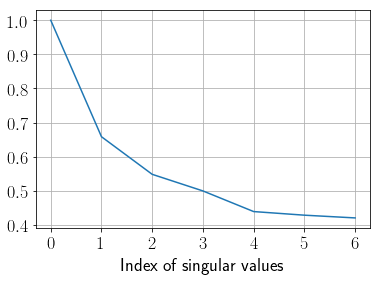

In [16]:
plt.plot(sigma[::-1]/sigma[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [17]:
terms = vectorizer.get_feature_names()
print(len(terms))
print(terms[:10])

1000
['ability', 'able', 'abortion', 'absolutely', 'abuse', 'accept', 'access', 'according', 'account', 'accounts']


### Topics anf the most relevant terms for them

In [18]:
for i, comp in enumerate(v):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print("Word: {}, score: {}".format(t[0], t[1]))

Topic 0: 
Word: health, score: 0.40862330747376874
Word: mental, score: 0.22240931303128725
Word: care, score: 0.22169596123074495
Word: patients, score: 0.20331924410163693
Word: people, score: 0.15992102366539657
Word: doctors, score: 0.14215598718119746
Word: hospital, score: 0.1325782197669305
Word: social, score: 0.11089865675449893
Word: says, score: 0.10809725354632962
Word: children, score: 0.10648923164782348
Topic 1: 
Word: film, score: 0.48038693031676405
Word: films, score: 0.12755665655401316
Word: movie, score: 0.1249785732242679
Word: director, score: 0.0846370876408235
Word: hollywood, score: 0.07996289850111983
Word: women, score: 0.07789731411556998
Word: health, score: 0.07000273851282515
Word: actor, score: 0.06921527165008458
Word: said, score: 0.055688664842670044
Word: drama, score: 0.055478115562781365
Topic 2: 
Word: bank, score: 0.4979364782266319
Word: banks, score: 0.23519917763522913
Word: film, score: 0.2138460671932756
Word: banking, score: 0.162724779306

### Topics and the most relevant documents for them

In [19]:
top_docs = np.argmax(u, axis=0)
print(top_docs)
for i, j in enumerate(top_docs):
    print("Topic {}".format(i))
    print(documents[j])
    print(" ")

[3116 2806 2414 2806 1057  464  658]
Topic 0
Public Service Awards 2016 health and wellbeing winner: Derventio Housing Trust “Quite often people are in hospital and they’ve got nothing: no food, no clothes, no toiletries,” says Kate Gillespie, Derventio Housing Trust’s strategic lead for its Healthy Futures initiative. “We get all that sorted out, so people at least have a bit of dignity when they are discharged.” That’s just the start of the scheme’s work with homeless people due to leave hospital. Many have multiple, complex needs, such as mental health problems and addictions, and are trapped in a vicious cycle of ongoing health issues and repeat admissions. Over a 12-week period, staff work intensively to find housing for patients, settle them into their new homes and help them live independently – while making better use of primary care, rather than relying disproportionately on acute services. “Sometimes it’s because they don’t manage their health, so they actually get ill enough

### Let us find the closest document to the given one

In [20]:
new_request_original = '''There were four minutes remaining and none of the Newcastle United fans had left. 
Even with their team a man down and four goals down, they stayed. 
Even with another reminder of how their well-intentioned manager, Steve Bruce, 
struggles to build on the good work of Rafa Benítez, 
they kept standing there, kept singing, defying the rain and the pain.'''

# removing everything except alphabets`
new_request = new_request_original.replace("[^a-zA-Z#]", " ")

# removing short words
new_request = ' '.join([w for w in new_request.split() if len(w)>3])

# make all text lowercase
new_request = new_request.lower()


# tokenization
tokenized_doc = new_request.split()

# remove stop-words
tokenized_doc = [item for item in tokenized_doc if item not in stop_words]

# de-tokenization
detokenized_request = ' '.join(tokenized_doc)

y = vectorizer.transform([detokenized_request]).toarray().T
y.shape, v.shape

((1000, 1), (7, 1000))

In [21]:
score = u @ (sigma[:, np.newaxis] * v.dot(y))
print(score.shape)
idx_best = np.argmax(score)
print(documents[idx_best])

(4551, 1)
Premier League: 10 things to look out for this weekend 1) Start of a tough run for the Hammers On the last day of the 2006-07 season Manchester United, who had won the title five days earlier, fielded a weakened side – Cristiano Ronaldo, Ryan Giggs, Paul Scholes, Rio Ferdinand and Nemanja Vidic were all left out of the starting XI – at Old Trafford against a West Ham team who needed at least a point to avoid relegation. Carlos Tevez, who was to join United a few weeks later, scored the only goal on the stroke of half-time. “They couldn’t have come to Old Trafford on a better day,” said Sir Alex Ferguson after the game. “We had already won the league and the edge was off our game.” There was also a 1-0 win in December 2001, against a wretchedly out-of-form United side that were completing a memorably horrific run of five defeats in seven league games. Those two games are the Hammers’ only highlights in a miserable run of top-flight visits to Old Trafford that now extends over 

In [22]:
print(sorted(score.ravel())[::-1][:10])

[0.1926413029576342, 0.18637279384967628, 0.18464519140512234, 0.1829021315603602, 0.18210910662170277, 0.17802423126548572, 0.1774632399857713, 0.1771421467788238, 0.17574163035083412, 0.17550382215861288]


## Application 2: recommender systems

### What data do we have?

- Matrix user-item
- Elements of the matrix are ratings
- A lot of missing data

## How can we use SVD?

- Original paper [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Construct embeddings of users and items in some subspace of $\mathbb{R}^n$
- For known users preferences we can find the most relevant items in this subspace
- How can we compute it?

### Movielens dataset with ratings of movies

In [24]:
movies = pd.read_csv('../files/movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('../files/ratings.gz', header=0)

### Example of entry

In [25]:
movies.head()

movienm                         genreid
movieid                                                                    
1                          Toy Story (1995)   Animation, Children's, Comedy
2                            Jumanji (1995)  Adventure, Children's, Fantasy
3                   Grumpier Old Men (1995)                 Comedy, Romance
4                  Waiting to Exhale (1995)                   Comedy, Drama
5        Father of the Bride Part II (1995)                          Comedy

In [26]:
ratings.head()

userid  movieid  rating
0       1     1193       5
1       1      661       3
2       1      914       3
3       1     3408       4
4       1     2355       5

### Set the list of preferences

In [27]:
best_movies = "matrix|die hard"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

movienm                   genreid
movieid                                                             
165      Die Hard: With a Vengeance (1995)          Action, Thriller
1036                       Die Hard (1988)          Action, Thriller
1370                     Die Hard 2 (1990)          Action, Thriller
2571                    Matrix, The (1999)  Action, Sci-Fi, Thriller

### Find the indices of the favourite films

In [28]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([165, 1036, 1370, 2571], dtype='int64', name='movieid')


### Create matrix with ratings

In [29]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Compute SVD

In [30]:
rank = 30
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Check decreasing of the singular values

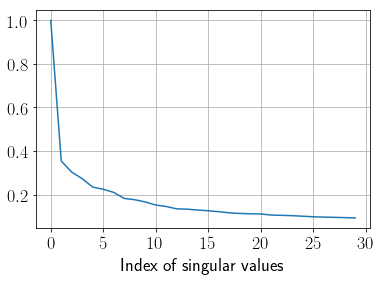

In [31]:
plt.plot(S[::-1] / S[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

### Compute correlations

In [32]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(30, 4)
(3953, 4)
(3953,)


### Compute resulting recommendations

In [33]:
top_n = 10
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.15287975 0.15033298 0.14251449 0.12089341 0.11414237 0.10847293
 0.10257672 0.09429381 0.09029753 0.0862588 ]


movienm  \
movieid                                      
457                   Fugitive, The (1993)   
2571                    Matrix, The (1999)   
589      Terminator 2: Judgment Day (1991)   
1610      Hunt for Red October, The (1990)   
1036                       Die Hard (1988)   
1240                Terminator, The (1984)   
377                           Speed (1994)   
2916                   Total Recall (1990)   
1370                     Die Hard 2 (1990)   
2353             Enemy of the State (1998)   

                                     genreid  
movieid                                       
457                         Action, Thriller  
2571                Action, Sci-Fi, Thriller  
589                 Action, Sci-Fi, Thriller  
1610                        Action, Thriller  
1036                        Action, Thriller  
1240                Action, Sci-Fi, Thriller  
377                Action, Romance, Thriller  
2916     Action, Adventure, Sci-Fi, Thriller  
1370                        Action, Thriller  
2353                        Action, Thriller

## Generalizations 

- If we try to use context in our model, we have to introduce a new Gram matrix for scalar product. We have **hybrid model**, more details see in [this paper](https://arxiv.org/pdf/1802.06398.pdf)
- [Blog about recommender systems with technical details](https://www.eigentheories.com/archive.html#)

## Principal Component Analysis
### Intuition
Imagine, that you have a dataset of points. Your goal is to choose orthogonal axes, that describe your data the most informative way. To be precise, we choose first axis in such a way, that maximize the variance (expressiveness) of the projected data. All the following axes have to be orthogonal to the previously chosen ones, while satisfy largest possible variance of the projections. 

Let's take a look at the simple 2d data. We have a set of blue points on the plane. We can easily see that the projections on the first axis (red dots) have maximum variance at the final position of the animation. The second (and the last) axis should  be orthogonal to the previous one.
![](https://i.stack.imgur.com/lNHqt.gif)
[source](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

This idea could be used in a variety ways. For example, it might happen, that projection of complex data on the principal plane (only 2 components) bring you enough intuition for clustering. The picture below plots projection of the labeled dataset onto the first to principal components (PC's), we can clearly see, that only two vectors (these PC's) would be enogh to differ Finnish people from Italian in particular dataset (celiac disease (Dubois et al. 2010))
![](https://nla.skoltech.ru/files/pca_example.png)
[source](https://privefl.github.io/bigsnpr/articles/how-to-PCA.html)

### Problem
The first component should be defined in order to maximize variance. Suppose, we've already normalized the data, i.e. $\sum\limits_i a_i = 0$, then sample variance will become the sum of all squared projections of data points to our vector ${\mathbf  {w}}_{{(1)}}$, which implies the following optimization problem:
$$
{\mathbf  {w}}_{{(1)}}={\underset  {\Vert {\mathbf  {w}}\Vert =1}{\operatorname {\arg \,max}}}\,\left\{\sum _{i}\left({\mathbf  {a}}_{{(i)}}\cdot {\mathbf  {w}}\right)^{2}\right\}
$$

or

$$
 \mathbf {w} _{(1)}={\underset {\Vert \mathbf {w} \Vert =1}{\operatorname {\arg \,max} }}\,\{\Vert \mathbf {Aw} \Vert ^{2}\}={\underset {\Vert \mathbf {w} \Vert =1}{\operatorname {\arg \,max} }}\,\left\{\mathbf {w} ^{\top}\mathbf {A^{\top}} \mathbf {Aw} \right\}
$$

since we are looking for the unit vector, we can reformulate the problem:

$$
{\displaystyle \mathbf {w} _{(1)}={\operatorname {\arg \,max} }\,\left\{{\frac {\mathbf {w} ^{\top}\mathbf {A^{\top}} \mathbf {Aw} }{\mathbf {w} ^{\top}\mathbf {w} }}\right\}}
$$

It is [known](https://en.wikipedia.org/wiki/Rayleigh_quotient), that for positive semidefinite matrix $A^\top A$ such vector is nothing else, but eigenvector of $A^\top A$, which corresponds to the largest eigenvalue. The following components will give you the same results (eigenvectors).

So, we can conclude, that the following mapping:

$$
\underset{n \times k}{\Pi} = \underset{n \times d}{A} \cdot \underset{d \times k}{W} 
$$

describes the projection of data onto the $k$ principal components, where $W$ contains first (by the size of eigenvalues) $k$ eigenvectors of $A^\top A$.

Now we'll briefly derive how SVD decomposition could lead us to the PCA.

Firstly, we write down SVD decomposition of our matrix:

$$
A = U \Sigma W^\top
$$

and to its transpose:

$$
\begin{align}
A^\top
&= (U \Sigma W^\top)^\top \\
&= (W^\top)^\top \Sigma^\top U^\top \\
&= W \Sigma^\top U^\top \\
&= W \Sigma U^\top
\end{align}
$$



Then, consider matrix $A A^\top$:

$$
\begin{align}
A^\top A
&= (W \Sigma U^\top)(U \Sigma V^\top)  \\
&= W \Sigma I \Sigma W^\top \\
&= W \Sigma \Sigma W^\top \\
&= W \Sigma^2 W^\top
\end{align}
$$

Which corresponds to the eigendecomposition of matrix $A^\top A$, where $W$ stands for the matrix of eigenvectors of $A^\top A$, while $\Sigma^2$ contains eigenvalues of $A^\top A$.

At the end:
$$
\begin{align}
\Pi &= A \cdot W =\\
 &= U \Sigma W^\top W = U \Sigma
\end{align}
$$

The latter formula provide us with easy way to compute PCA via SVD with any number of principal components:
$$
\Pi_r = U_r \Sigma_r
$$

### Example. 🌼Iris dataset
Consider the classical Iris dataset
![](https://sebastianraschka.com/images/blog/2015/principal_component_analysis_files/iris.png)
[source](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

We have the dataset matrix $A \in \mathbb{R}^{150 \times 4}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris        = load_iris()
A           = iris['data']
labels      = iris['target']
classes     = iris['target_names']
label_names = np.array([classes[label] for label in labels])
colours     = ['red', 'blue', 'green']
print('🤖: Dataset contains {} points in {}-dimensional space'.format(*A.shape))

🤖: Dataset contains 150 points in 4-dimensional space


In [2]:
# Data normalization with zero mean and unit variance
A_std = StandardScaler().fit_transform(A)

u,s,wh = np.linalg.svd(A_std)

[]

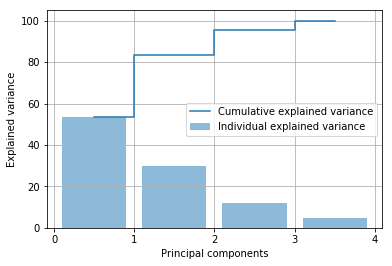

In [3]:
total_variance = sum(s)
variance_explained = [(i / total_variance)*100 for i in sorted(s, reverse=True)]
cumulative_variance_explained = np.cumsum(variance_explained)

xs = [0.5 + i for i in range(4)]
plt.bar(xs, variance_explained, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(xs, cumulative_variance_explained, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.xticks([0,1,2,3,4])
plt.grid()
plt.plot()

In [4]:
rank = 2
w = wh.T
projections = u[:,:rank] @ np.diag(s[:rank])

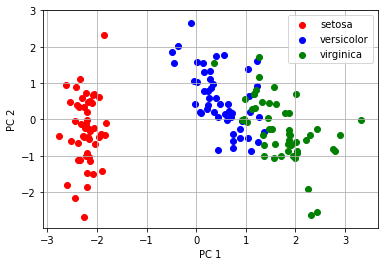

In [5]:
for label, colour in zip(classes, colours):
    plt.scatter(projections[label_names == label, 0],
                projections[label_names == label, 1],
                label = label,
                c = colour)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.grid()
plt.show()

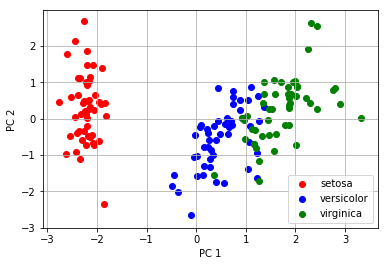

In [6]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
projections_sklearn = sklearn_pca.fit_transform(A_std)

for label, colour in zip(classes, colours):
    plt.scatter(projections_sklearn[label_names == label, 0],
                projections_sklearn[label_names == label, 1],
                label = label,
                c = colour)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.grid()
plt.show()

### Example. 🍷 Wine dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine #lol
from sklearn.preprocessing import StandardScaler

wine        = load_wine()
A           = wine['data']
labels      = wine['target']
classes     = wine['target_names']
label_names = np.array([classes[label] for label in labels])
colours     = ['red', 'blue', 'green']
print('🤖: Dataset contains {} points in {}-dimensional space'.format(*A.shape))

# Data normalization with zero mean and unit variance
A_std = StandardScaler().fit_transform(A)

u,s,wh = np.linalg.svd(A_std)

total_variance = sum(s)
variance_explained = [(i / total_variance)*100 for i in sorted(s, reverse=True)]
cumulative_variance_explained = np.cumsum(variance_explained)

🤖: Dataset contains 178 points in 13-dimensional space


In [ ]:
xs = [0.5 + i for i in range(13)]
plt.bar(xs, variance_explained, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(xs, cumulative_variance_explained, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.xticks([0,1,2,3,4])
plt.grid()
plt.plot()

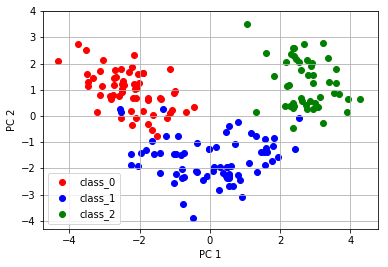

In [10]:
rank = 2
projections = u[:,:rank] @ np.diag(s[:rank])

for label, colour in zip(classes, colours):
    plt.scatter(projections[label_names == label, 0],
                projections[label_names == label, 1],
                label = label,
                c = colour)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.grid()
plt.show()

### Related materials
* [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)